In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Initialize folder path
folder_path = r"C:\Users\Asus\Downloads\Quant Value"

# Step 1: Load historical price data with inner join
def load_data(folder_path):
    files = os.listdir(folder_path)
    print(f"Files found in {folder_path}: {files}")  # Print files found
    stock_data_list = []
    
    total_files_processed = 0
    valid_files_count = 0
    
    for file in files:
        if file.endswith('.csv'):
            total_files_processed += 1
            print(f"Processing file: {file}")  # Indicate which file is being processed
            
            # Load the stock data and check the columns
            stock_data = pd.read_csv(os.path.join(folder_path, file))
            print(f"Initial columns in {file}: {stock_data.columns.tolist()}")  # Print the columns in the loaded data
            
            # Check if required columns are present
            if 'Date' not in stock_data.columns or 'Close Price' not in stock_data.columns:
                print(f"Warning: 'Date' or 'Close Price' not found in {file}. Skipping this file.")
                continue
            
            # Rename the 'Adj Close' column to ensure uniqueness
            stock_name = file.split('.')[0]  # Extract the stock name from the file name
            stock_data = stock_data.rename(columns={'Close Price': f'{stock_name } Close'})
            stock_data_list.append(stock_data[['Date', f'{stock_name} Close']])  # Append only relevant columns
            valid_files_count += 1

    # Start merging the dataframes using inner join
    if not stock_data_list:
        print("No valid stock data found. Exiting.")
        return None

    print(f"Merging dataframes... Total valid files: {valid_files_count}")
    combined_data = stock_data_list[0]  # Start with the first stock data
    
    for stock_data in stock_data_list[1:]:
        combined_data = combined_data.merge(stock_data, on='Date', how='inner')  # Inner join to keep only common dates
    
    # Ensure Date column is in datetime format and sorted
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])
    combined_data = combined_data.set_index('Date').sort_index()
    
    print("Combined data shape:", combined_data.shape)  # Print shape of combined data
    print("Top 5 rows of combined data:\n", combined_data.head())  # Print top 5 rows
    print(f"Total files processed: {total_files_processed}, Valid files merged: {valid_files_count}")
    
    return combined_data

# Main execution
data = load_data(folder_path)  # Call the function to load data


Files found in C:\Users\Asus\Downloads\Quant Value: ['Adani.csv', 'Aditya Birla.csv', 'Bajaj Consumer.csv', 'Birlasoft.csv', 'Confidence Petroleum.csv', 'Gujarat Themis.csv', 'HDFCLIFE.csv', 'Heubach Colorants.csv', 'HFCL.csv', 'Himadri Speciality.csv', 'ITC.csv', 'Jamna Auto.csv', 'Kovai Medical.csv', 'Mangalam Cement.csv', 'Orient Cement.csv', 'Oriental Hotel.csv', 'Piramal Enterprise.csv', 'Reliance.csv', 'SunTV.csv', 'Tata Power.csv']
Processing file: Adani.csv
Initial columns in Adani.csv: ['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'WAP', 'No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)', 'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread High-Low', 'Spread Close-Open']
Processing file: Aditya Birla.csv
Initial columns in Aditya Birla.csv: ['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'WAP', 'No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)', 'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread High-Low', 'Sprea

In [2]:
# Step 2: Calculate daily returns
def calculate_returns(data):
    returns = data.pct_change().dropna()
    print("Calculated daily returns:")
    print(returns.head())  # Print top 5 rows of returns
    return returns

# Step 3: Generate random portfolio weights with a max weight constraint (9.99%)
def generate_random_portfolios(num_portfolios, num_stocks, max_weight=0.0999):
    weights = np.zeros((num_portfolios, num_stocks))
    
    for i in range(num_portfolios):
        while True:
            random_weights = np.random.random(num_stocks)  # Generate random weights
            # Normalize weights to sum to 1
            normalized_weights = random_weights / np.sum(random_weights)
            # Check if any weight exceeds max_weight
            if np.all(normalized_weights <= max_weight):
                weights[i] = normalized_weights
                break  # Exit the loop when valid weights are found

    print(f"Generated {num_portfolios} random portfolios with {num_stocks} stocks each.")
    return weights

# Step 4: Calculate portfolio returns and risk
def portfolio_performance(weights, returns):
    portfolio_return = np.sum(weights * returns.mean() * 252)  # Annualized return
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized risk
    return portfolio_return, portfolio_stddev

# Step 5: Run the simulation and store results with the best portfolio's weights
def run_simulation(data, num_portfolios=10000, risk_free_rate=0.065):
    returns = calculate_returns(data)
    num_stocks = returns.shape[1]
    
    portfolios = generate_random_portfolios(num_portfolios, num_stocks)
    results = np.zeros((num_portfolios, 3))  # For storing returns, risks, and Sharpe ratios
    
    # Convert the annual risk-free rate to a daily rate (assuming 252 trading days in a year)
    daily_risk_free_rate = (1 + risk_free_rate)**(1/252) - 1
    
    print("Running simulations...")
    for i in range(num_portfolios):
        portfolio_return, portfolio_stddev = portfolio_performance(portfolios[i], returns)
        # Adjust the Sharpe ratio formula to account for the risk-free rate
        results[i, 0] = portfolio_return
        results[i, 1] = portfolio_stddev
        excess_return = portfolio_return - risk_free_rate  # Annualized excess return over risk-free rate
        results[i, 2] = excess_return / portfolio_stddev  # Sharpe Ratio
    
    print("Simulation complete.")
    
    # Find the best portfolio
    max_sharpe_idx = results[:, 2].argmax()  # Index of the max Sharpe ratio
    best_portfolio_weights = portfolios[max_sharpe_idx]  # Weights of the best portfolio

    # Get stock names from the data
    stock_names = data.columns.tolist()
    
    # Convert weights to percentage terms
    best_portfolio_weights_percentage = best_portfolio_weights * 100
    
    # Create a DataFrame for better readability
    best_portfolio_df = pd.DataFrame({
        'Stock': stock_names,
        'Weight (%)': best_portfolio_weights_percentage
    })

    print("Best portfolio's weights (in %):\n", best_portfolio_df)
    print("Best portfolio's Sharpe Ratio:", results[max_sharpe_idx, 2])
    
    return results, best_portfolio_df

# Example usage:
# results, best_portfolio_df = run_simulation(data, num_portfolios=10000, risk_free_rate=0.065)

import matplotlib.pyplot as plt

def plot_efficient_frontier(results, best_portfolio_weights, stock_names):
    # Plotting the Efficient Frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(results[:, 1], results[:, 0], c=results[:, 2], cmap='viridis', marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.grid(True)
    
    # Highlight the portfolio with the maximum Sharpe Ratio
    max_sharpe_idx = results[:, 2].argmax()
    plt.scatter(results[max_sharpe_idx, 1], results[max_sharpe_idx, 0], c='red', marker='*', s=200, label='Max Sharpe Ratio')
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    
def plot_best_portfolio_weights(best_portfolio_weights, stock_names):
    plt.figure(figsize=(10, 6))
    
    # Plot the bar chart
    bars = plt.bar(stock_names, best_portfolio_weights * 100)  # Multiply by 100 to show percentage
    plt.title('Best Portfolio Weights')
    plt.xlabel('Stock')
    plt.ylabel('Weight (%)')
    plt.xticks(rotation=90)
    
    # Annotating the bars with the weight percentage
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


Files found in C:\Users\Asus\Downloads\Quant Value: ['Adani.csv', 'Aditya Birla.csv', 'Bajaj Consumer.csv', 'Birlasoft.csv', 'Confidence Petroleum.csv', 'Gujarat Themis.csv', 'HDFCLIFE.csv', 'Heubach Colorants.csv', 'HFCL.csv', 'Himadri Speciality.csv', 'ITC.csv', 'Jamna Auto.csv', 'Kovai Medical.csv', 'Mangalam Cement.csv', 'Orient Cement.csv', 'Oriental Hotel.csv', 'Piramal Enterprise.csv', 'Reliance.csv', 'SunTV.csv', 'Tata Power.csv']
Processing file: Adani.csv
Initial columns in Adani.csv: ['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'WAP', 'No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)', 'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread High-Low', 'Spread Close-Open']
Processing file: Aditya Birla.csv
Initial columns in Aditya Birla.csv: ['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'WAP', 'No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)', 'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread High-Low', 'Sprea

Generated 10000 random portfolios with 20 stocks each.
Running simulations...
Simulation complete.
Best portfolio's weights (in %):
                          Stock  Weight (%)
0                  Adani Close    9.032450
1           Aditya Birla Close    6.269937
2         Bajaj Consumer Close    3.929122
3              Birlasoft Close    2.900073
4   Confidence Petroleum Close    2.041378
5         Gujarat Themis Close    8.294579
6               HDFCLIFE Close    3.674816
7      Heubach Colorants Close    1.230741
8                   HFCL Close    6.933806
9     Himadri Speciality Close    4.910369
10                   ITC Close    1.987677
11            Jamna Auto Close    4.960872
12         Kovai Medical Close    9.122318
13       Mangalam Cement Close    3.314915
14         Orient Cement Close    4.078594
15        Oriental Hotel Close    7.624869
16    Piramal Enterprise Close    0.082713
17              Reliance Close    9.782472
18                 SunTV Close    1.905629
19     

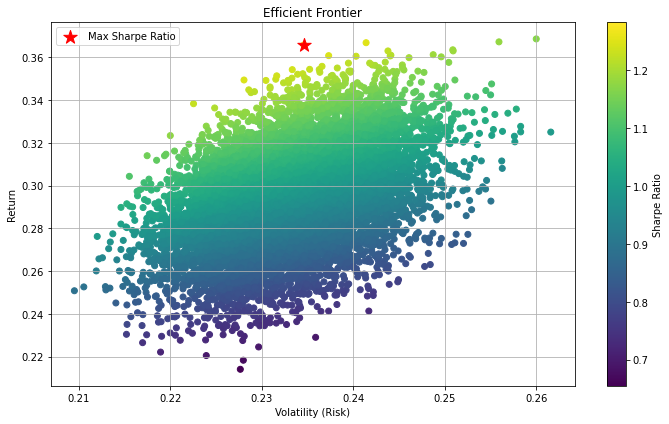

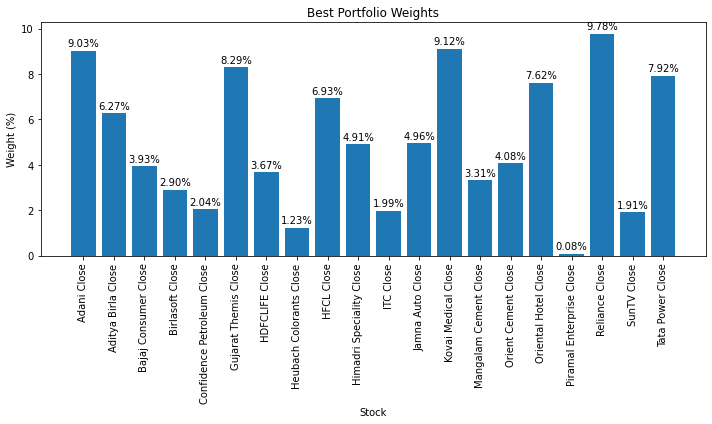

In [3]:
def main(data):
    # Load and prepare data
    stock_names = data.columns.tolist()  # Stock names are the column names of the data
    
    # Run portfolio simulation
    num_portfolios = 10000
    results, best_portfolio_df = run_simulation(data, num_portfolios=num_portfolios)
    
    # Extract best portfolio weights from the DataFrame
    best_portfolio_weights = best_portfolio_df['Weight (%)'].values / 100  # Convert percentages back to decimals

    # Plot Efficient Frontier and Best Portfolio Weights
    plot_efficient_frontier(results, best_portfolio_weights, stock_names)  # Pass all arguments
    plot_best_portfolio_weights(best_portfolio_weights, stock_names)  # Bar chart of the best portfolio's weights

# Assuming the data (daily adjusted close prices for multiple stocks) is already loaded
# Main execution
folder_path = r"C:\Users\Asus\Downloads\Quant Value"  # Update this to your folder path

# Step 1: Load the combined data
data = load_data(folder_path)

# Drop NaN values to align data (if necessary, after merging different stocks)
aligned_data = data.dropna()

# Step 2: Run simulation
results, best_portfolio_df = run_simulation(aligned_data)

# Step 3: Extract weights for the best portfolio
best_portfolio_weights = best_portfolio_df['Weight (%)'].values / 100  # Convert percentages to decimals

# Step 4: Plot the Efficient Frontier
plot_efficient_frontier(results, best_portfolio_weights, aligned_data.columns)

# Step 5: Plot Best Portfolio Weights using Bar Chart
plot_best_portfolio_weights(best_portfolio_weights, aligned_data.columns)
